**Introduction**

Using meta-learning for domain adaptation is a powerful approach to improving a model's ability to generalize across different data distributions. Instead of adapting a single model directly to a new domain, meta-learning teaches the model how to adapt efficiently by learning across multiple related domains.

MAML (Model-Agnostic Meta-Learning) is often one of the first choices for meta-learning in domain adaptation, especially when the goal is quick adaptation to new tasks or distributions.

**What Makes Your Implementation MAML?**

A CNN-based MAML retains the standard principles of Model-Agnostic Meta-Learning (MAML) but integrates convolutional neural networks (CNNs) as the base architecture for feature extraction and adaptation.

**Imports**

In [1]:
# !pip install "deeplake<4"

In [2]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# !python -Xfrozen_modules=off your_script.py
!free -h


               total        used        free      shared  buff/cache   available
Mem:           334Gi       2.0Gi       331Gi        10Mi       1.5Gi       330Gi
Swap:             0B          0B          0B


In [3]:
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

import deeplake
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset

import copy
import random

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# import torch_xla.core.xla_model as xm

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.6) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# device = xm.xla_device()  # ✅ Detect TPU
# print("Using device:", device)

device(type='cpu')

**Data Processing**

In [5]:
ds_train = deeplake.load("hub://activeloop/pacs-train")

\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



\

hub://activeloop/pacs-train loaded successfully.



In [6]:
# # Initialize accumulators
# mean = torch.zeros(3)  # Assuming RGB images
# std = torch.zeros(3)
# num_pixels = 0

# # Compute mean
# for sample in ds_train.images:  # Assuming 'images' is the correct key
#     img = sample.numpy() / 255.0  # Normalize to [0,1]

#     # Move channels to first dimension (C, H, W)
#     img = np.moveaxis(img, -1, 0)

#     # Accumulate per-channel mean
#     mean += torch.tensor(img).mean(dim=(1, 2))
#     num_pixels += 1

# mean /= num_pixels  # Normalize mean across dataset

# # Compute standard deviation
# num_pixels = 0
# for sample in ds_train.images:
#     img = sample.numpy() / 255.0
#     img = np.moveaxis(img, -1, 0)  # Ensure (C, H, W) format

#     # Compute squared differences
#     std += ((torch.tensor(img) - mean.unsqueeze(-1).unsqueeze(-1)) ** 2).mean(dim=(1, 2))
#     num_pixels += 1

# std = torch.sqrt(std / num_pixels)  # Final standard deviation calculation

# print(f"Mean: {mean.tolist()}, Std: {std.tolist()}")

In [7]:
ds_val = deeplake.load("hub://activeloop/pacs-val")

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-val



/

hub://activeloop/pacs-val loaded successfully.



In [8]:

# Print unique domain labels
print("Unique domain labels:", np.unique(ds_train.domains.numpy()))


Unique domain labels: [0 1 2 3]


In [9]:
domain_mapping = {
    "photo": 0,
    "art_painting": 1,
    "cartoon": 2,
    "sketch": 3
}


In [10]:
def filter_by_domain(ds, domain_name):
    domain_array = ds.domains.numpy()

    # Convert domain name to numerical label
    domain_label = domain_mapping.get(domain_name)
    if domain_label is None:
        raise ValueError(f"Invalid domain name: {domain_name}. Must be one of {list(domain_mapping.keys())}")

    # Get indices where domain matches
    indices = np.where(domain_array == domain_label)[0].tolist()

    if not indices:
        raise ValueError(f"No samples found for domain '{domain_name}'")

    # Properly filter the tensors
    return {
        "images": ds.images[indices].numpy(),
        "labels": ds.labels[indices].numpy(),
        "domains": ds.domains[indices].numpy()
    }



In [11]:
mean = [0.3597, 0.2943, 0.2461]
std = [0.3044, 0.3065, 0.3334]

# Mean: tensor([0.3597, 0.2943, 0.2461])
# Std: tensor([0.3044, 0.3065, 0.3334])


simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7637, 0.7441, 0.7155], std=[0.3086, 0.3180, 0.3463])

    ])


pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),  #  Standardize input size across domains

    # #   Spatial Augmentations (help domain adaptation)
    # transforms.RandomHorizontalFlip(p=0.5),  # Helps with mirror variations
    # transforms.RandomRotation(degrees=15),  # Adds slight rotation to combat domain shift
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crops simulate varied perspectives

    # #  Appearance Augmentations (reduce style bias)
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Varies color characteristics
    # transforms.RandomGrayscale(p=0.2),  # Helps adapt to Sketch and Cartoon domains

    # #  Noise-based Augmentations (improve robustness)
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Adds blur to mimic artistic distortions
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Introduces slight shifts & resizing

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


In [12]:
class PACSDataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data["images"]
        self.labels = data["labels"]
        self.transform = transform  #  Store transform function

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]

        # ✅ Convert NumPy array to PIL Image before applying transforms
        x = Image.fromarray(x.astype('uint8'))

        if self.transform:
            x = self.transform(x)  #  Apply transformation

        return x, y


In [13]:
batch_size = 16

# Create dataloaders
dataloaders_train = {
    domain: DataLoader(PACSDataset(filter_by_domain(ds_train, domain), transform=pacs_transform), batch_size=batch_size, shuffle=True, num_workers=3)
    for domain in domain_mapping.keys()
}

dataloaders_val = {
    domain: DataLoader(PACSDataset(filter_by_domain(ds_val, domain), transform=pacs_transform), batch_size=batch_size, shuffle=True, num_workers=3)
    for domain in domain_mapping.keys()
}


In [14]:
dataloaders_train

{'photo': <torch.utils.data.dataloader.DataLoader at 0x7aa537305a50>,
 'art_painting': <torch.utils.data.dataloader.DataLoader at 0x7aa547adf010>,
 'cartoon': <torch.utils.data.dataloader.DataLoader at 0x7aa53739b850>,
 'sketch': <torch.utils.data.dataloader.DataLoader at 0x7aa537290290>}

In [15]:
train_photo = dataloaders_train["photo"]
train_art_painting = dataloaders_train["art_painting"]
train_cartoon = dataloaders_train["cartoon"]
train_sketch = dataloaders_train["sketch"]

val_photo = dataloaders_val["photo"]
val_art_painting = dataloaders_val["art_painting"]
val_cartoon = dataloaders_val["cartoon"]
val_sketch = dataloaders_val["sketch"]

In [16]:
len(train_photo), len(train_art_painting), len(train_cartoon), len(train_sketch)

(115, 132, 94, 221)

In [17]:
train_photo

In [18]:
images, labels = next(iter(train_photo))
print(images.shape, labels.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 1])


In [19]:
tasks_train = [train_photo, train_art_painting, train_cartoon, train_sketch]



In [20]:
print(type(train_photo))

<class 'torch.utils.data.dataloader.DataLoader'>


In [21]:
val_tasks = [val_photo, val_art_painting, val_cartoon, val_sketch]


In [22]:
images, labels = next(iter(train_photo))
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([16, 3, 224, 224]) torch.Size([16, 1])


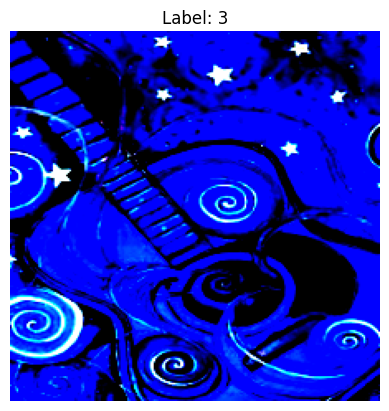

In [23]:
# Get a single batch from the DataLoader
batch = next(iter(val_photo))  #  Extract a batch
x, y = batch  #  Unpack images & labels

# Select a random image from the batch
idx = torch.randint(0, x.shape[0], (1,)).item()
image = x[idx].permute(1, 2, 0).cpu().numpy()  #  Convert for display

# Display the image
plt.imshow(image)
plt.title(f"Label: {y[idx].item()}")
plt.axis("off")
plt.show()

**Feature extractor**

In [24]:
class CNN_model(nn.Module):
    def __init__(self, in_channels=3, num_classes=7):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.dropout = nn.Dropout(0.5)

        #  Manually setting the flattened input size
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dropout(x)

        x = self.fc1(x)  # Fully connected layer
        x = self.relu(x)
        x = self.fc2(x)

        return x




**Inner Loop**


In [25]:
def maml_update(model, task_data, optim_lr, num_inner_updates=5):
    adapted_model = model.to(device)
    adapted_model.train()
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=optim_lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(num_inner_updates):
        for batch in task_data:  #  Properly iterating over DataLoader
            x, y = batch
            x = x.to(device).float()
            y = y.to(device).squeeze(-1).long()

            optimizer.zero_grad()
            output = adapted_model(x)

            loss = loss_fn(output, y)

            gradients = torch.autograd.grad(loss, adapted_model.parameters(), create_graph=True)

            for param, grad in zip(adapted_model.parameters(), gradients):
                param.data -= optim_lr * grad

    return adapted_model

**Outer Loop**

In [26]:
num_epochs = 5


# def maml_train(model, tasks, lr_inner, meta_optimizer, num_inner_updates=5):
#   torch.cuda.empty_cache()

#   for epoch in range(num_epochs):
#     meta_optimizer.zero_grad()
#     meta_loss = 0.0

#     for task_data in tasks:
#       adapted_model = maml_update(model, task_data, lr_inner)

#       for batch in task_data:  #  Inner Loop (Task-specific Training)
#           x_val, y_val = batch
#           x_val = x_val.to(device).float()
#           y_val = y_val.to(device).squeeze(-1).long()

#           output = adapted_model(x_val)

#           # print(f"Output shape before loss: {output.shape}")

#           meta_loss += nn.CrossEntropyLoss()(output, y_val)

#     # meta_loss /= (len(tasks) * len(task_data))
#     meta_loss /= (len(tasks) * num_inner_updates)

#     meta_loss.backward()
#     meta_optimizer.step()

#     print(f"Epoch {epoch+1}/{num_epochs}, Meta Loss: {meta_loss.item()}")

#   return model


def maml_train(model, tasks, lr_inner, meta_optimizer, num_inner_updates=5):
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        meta_loss = 0.0

        for task_data in tasks:  #  Loop over multiple DataLoaders
            adapted_model = maml_update(model, task_data, lr_inner)  #  Adapt model per task
            adapted_model.train()

            def closure():
                meta_optimizer.zero_grad()
                total_loss = 0.0

                for batch in task_data:  #  Now correctly iterating over individual DataLoader
                    x_val, y_val = batch
                    x_val = x_val.to(device).float()
                    y_val = y_val.to(device).squeeze(-1).long()

                    output = adapted_model(x_val)
                    total_loss += nn.CrossEntropyLoss()(output, y_val)

                total_loss /= num_inner_updates  #  Normalize loss
                total_loss.backward(retain_graph = False)
                return total_loss

            meta_loss += closure()  #  Remove unnecessary detach
            meta_optimizer.step(closure)  #  Update meta-model, not closure()

        print(f"Epoch {epoch+1}/{num_epochs}, Meta Loss: {meta_loss.item()}")

    return model  #  Ensure trained meta-model is returned


In [27]:
# for batch in mixed_dataloader:
#     print(f"Batch structure: {batch}")
#     break

In [28]:
model = CNN_model(3).to(device)
meta_optimizer = optim.LBFGS(model.parameters(), lr=0.001)

In [30]:
trained_model = maml_train(model, tasks_train, 0.005, meta_optimizer, num_inner_updates=5)

Epoch 1/5, Meta Loss: 5.114646911621094
Epoch 2/5, Meta Loss: 1.0625803470611572
Epoch 3/5, Meta Loss: 0.6059341430664062
Epoch 4/5, Meta Loss: 0.3680596947669983
Epoch 5/5, Meta Loss: 0.2131870985031128


meta-loss is consistently decreasing, which suggests the model is effectively learning how to adapt across tasks. The sharp drop in the first couple of epochs indicates that SGD is optimizing well, and later epochs show steady convergence.

In [31]:
def maml_eval(model, val_tasks, lr_inner):
    total_acc = 0.0

    for val_task_data in val_tasks:  #  Loop over validation DataLoaders
        adapted_model = maml_update(model, val_task_data, lr_inner)  # ✅ Adapt model per validation task

        correct, total = 0, 0
        for batch in val_task_data:  #  Iterate over task-specific DataLoader
            x_val, y_val = batch
            x_val = x_val.to(device).float()
            y_val = y_val.to(device).long().squeeze()

            output = adapted_model(x_val)
            preds = output.argmax(dim=1)  #  Get class predictions
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

        acc = correct / total  #  Compute accuracy per task
        total_acc += acc

    avg_acc = total_acc / len(val_tasks)  #  Compute final validation accuracy
    print(f"Meta-Test Accuracy: {avg_acc:.4f}")
    return avg_acc


In [32]:
maml_eval(trained_model, val_tasks, lr_inner=0.001)

Meta-Test Accuracy: 0.9615


0.9615269895124678

96.15% meta-test accuracy means your model is adapting really well across tasks. This suggests that your MAML implementation is effectively learning transferable knowledge from multiple domains.

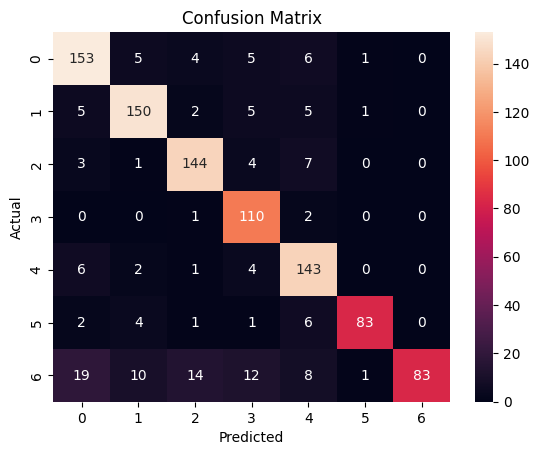

In [33]:
y_true, y_pred = [], []
for val_loader in val_tasks:  #  Iterate over each DataLoader (Photo, Art, Cartoon)
    for batch in val_loader:  #  Loop through batches inside each domain
        x_val, y_val = batch
        output = model(x_val)
        preds = output.argmax(dim=1)

        y_true.extend(y_val.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()